### <u> Using Soundfont (`sf2`) files in `strauss` </u>

Soundfont files conveniently package recorded samples of musical instruments together, to build realistic sounding virtual instruments. 

We can read such files into `strauss` when sonifying data!

First we import some modules:

/home/smangham/sonification-zooniverse-preproto/.venv/lib/python3.12/site-packages/stingray/utils.py:51: UserWarning: Numba not installed. Faking it
  warnings.warn("Numba not installed. Faking it")
/home/smangham/sonification-zooniverse-preproto/.venv/lib/python3.12/site-packages/stingray/utils.py:403: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


dt: 10.02


/home/smangham/sonification-zooniverse-preproto/.venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/smangham/sonification-zooniverse-preproto/.venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 0, 'Time (s)')

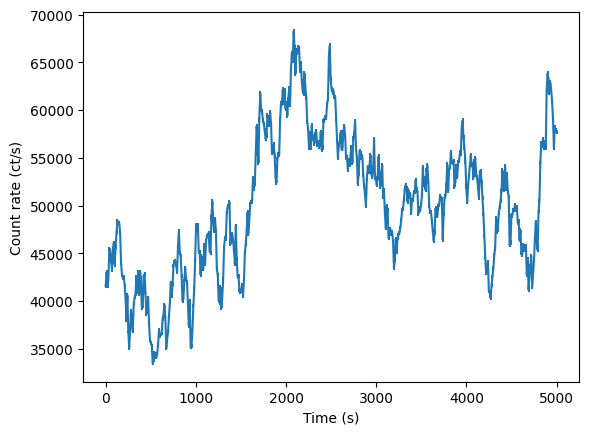

In [1]:
from mind_the_gaps.models.psd_models import Lorentzian as Lor
from mind_the_gaps.models.psd_models import SHO
from mind_the_gaps.models.psd_models import BendingPowerlaw

from mind_the_gaps.simulator import Simulator
import matplotlib.pyplot as plt
import numpy as np
Npoints = 500
times = np.linspace(0, 5000, Npoints)
dt = np.diff(times)[0]
print("dt: %.2f" % dt)

exposures = 1 * np.ones(Npoints)  # higher = better (i.e. less poisson noise), original = 5 
# Length of sample in seconds, we can leave at 1 and just adjust the mean

mean = 50000 # higher = better (i.e. less poisson noise), original = 50
# Baseline rate in the simulator

Fvar = 0.3  # Variance / mean, goes as high as 0.5 in AGN
variance = Fvar **2 * mean**2  # Amplitude, will affect dominance when multiple models combined
# By defining relative to the mean it makes it easier to understand/set ratios

period = 1000
w0 = 2 * np.pi / period # angular freq
logw0 = np.log(w0)
Q = 5 # coherence higher = more periodic, original = 5
logQ = np.log(Q)

lorentzian_model = Lor(S0=variance, omega0=w0, Q=Q)
sho_model = SHO(S0=variance, omega0=w0, Q=Q)
bpl_model = BendingPowerlaw(S0=variance, omega0=w0, Q=Q)  # This is a damped random walk, so no actual periodic element
# Can combine with Lorentzian, probably want to dial up and down variances of each

simulator = Simulator(bpl_model, times, exposures, mean=mean, pdf="Gaussian", extension_factor=2)
countrates = simulator.generate_lightcurve()
noisy_countrates, uncertainties = simulator.add_noise(countrates)
plt.errorbar(times, noisy_countrates, yerr=uncertainties)
plt.ylabel("Count rate (ct/s)")
plt.xlabel("Time (s)")



In [2]:
%reload_ext autoreload 
%autoreload 2
import matplotlib.pyplot as plt
from strauss.sonification import Sonification
from strauss.sources import Objects, Events
from strauss import channels
from strauss.score import Score
import numpy as np
from strauss.generator import Sampler
import IPython.display as ipd
import glob
import os
import copy
from pathlib import Path
%matplotlib inline

/home/smangham/sonification-zooniverse-preproto/.venv/lib/python3.12/site-packages/strauss/generator.py:46: SyntaxWarning: invalid escape sequence '\('
  warnings.filterwarnings("ignore", message="Chunk \(non-data\) not understood, skipping it\.")
/home/smangham/sonification-zooniverse-preproto/.venv/lib/python3.12/site-packages/strauss/notes.py:21: SyntaxWarning: invalid escape sequence '\D'
  nsplit = re.findall("(\D+|\d+)", notename)
/home/smangham/sonification-zooniverse-preproto/.venv/lib/python3.12/site-packages/strauss/utilities.py:101: SyntaxWarning: invalid escape sequence '\c'
  """
/home/smangham/sonification-zooniverse-preproto/.venv/lib/python3.12/site-packages/strauss/score.py:64: SyntaxWarning: invalid escape sequence '\s'
  regex = "([0-9]*)m\s*([0-9]*.[0-9]*)s"


...and then download some soundfont (`sf2`) files. These are widely available online, and in particular we download some collected on the [_Soundfonts 4 U_](https://sites.google.com/site/soundfonts4u/) website (and hsted on _Google Drive_). Why not experiment with some of the other files hosted here? We select a flute and a collection of guitar sounds as these are small enough to automatically download.

Don't worry too much about this code, you can equally download these files through your browser if you find this more convenient

In [3]:
outdir = Path("..", "data", "samples", "soundfonts")

if list(Path(f"{outdir}").glob("*.sf2")):
    print(f"Directory {outdir} with sf2 files already exists.")
else:
    print("Downloading files...")
    import urllib.request
    import os

    path = Path(outdir)
    path.mkdir(parents=True, exist_ok=True)
    path = str(path)
    # path = os.path.realpath(outdir)
    
    files = ("guitars.sf2", "flute.sf2")
    urls = ("https://drive.google.com/uc?export=download&id=18CCYj8AFy7wpDdGg0ADx8GfTTHEFilrs",
           "https://drive.google.com/uc?export=download&id=1DAbIitPRUUGidrhVt4wiwwXrSxOD7RDY")
    for f, u in zip(files, urls):
        with urllib.request.urlopen(u) as response, Path(f"{path}",f"{f}").open(mode='wb') as out_file:
            print(f"\t getting {f}")
            data = response.read() # a `bytes` object
            out_file.write(data)
    print("Done.")

Directory ../data/samples/soundfonts with sf2 files already exists.


Now we have these files, lets try loading them into the sampler.

First the ***flute*** soundfont. Generally soundfonts can store multiple different instruments or sets of sounds as `"presets"`. The flute file has just a single flute instruments, so if we load this file it should pick this preset automatically with no complaints.

In [4]:
flute_sampler = Sampler(Path(outdir,"flute.sf2"))

On the other hand, the ***guitar*** file has multiple presets. If we try loading this in in the same way, the `_strauss_` sampler will default to picking the first preset to use, but will print a list of all of the presets and thier associated numbers.

In [5]:
guitar_sampler = Sampler(Path(outdir, "guitars.sf2"))

valid 'sf_preset' not provided for soundfont file, available presets are:

----------------------------------------
1. "Banjo 5 String"
2. "Steel Guitar"
3. "Steel Layered Mute"
4. "Steel Low Vel Mute"
5. "12 String Guitar"
6. "Nylon Guitar"
7. "Clean Guitar"
8. "Chorus Guitar"
9. "Single Coil Dry"
10. "Single Coil FX"
11. "Single Coil FX Pick"
12. "Single Coil Muted"
13. "LP Twin Elec Gtr"
14. "LP Twin Pick Gtr"
15. "LP Twin Muted"
16. "Jazz Guitar"
17. "Jazz Guitar 2"
18. "Jazz Guitar 3"
19. "Overdrive Guitar"
20. "Overdrive Gtr Pick"
21. "Distortion Guitar"
22. "Distn Gtr Pick"
----------------------------------------

By default choosing preset 1 ("Banjo 5 String").

Re-run 'Sampler' with the 'sf_preset' keyword argument to select a specific
preset, ie. 'Sampler("../data/samples/soundfonts/guitars.sf2",sf_preset=N)',
where N is an integer from 1-22.



This can be useful to inspect whats inside the soundfont file. If we already know which preset we want (by e.g. inspecting this list), we can pick the preset ahead of time, using the `sf_preset` keyword argument:

In [6]:
sf_preset = 19
guitar_sampler= Sampler(Path(outdir, "guitars.sf2"), sf_preset=sf_preset)

So, lets try using these files to sonify data series. We use light-curve data packaged for the star `55 Cancri`. This provides a noisy data set with interesting long and short term variations, as well as a gap in the data.

First, we can articulate each data-point using individual musical notes, chosen from a musical scale (`C Major Pentatonic`). We visualise this using a scztter plot, where each data point is repreesented individually.

When listening to many data points in quick succession, the _"note_length"_ and _"volume_envelope_" can be important, i.e. how the loudness of the sound changes over time. If each note plays for a long time, we could lose track of the individual notes. We want each note to be a short burst of sound - _"staccato"_ in musical terms. Here we set parameters to achieve this manually, but you can also just use the _`"staccato"`_ preset for the `Sampler` (commented out).

Here, we use 0.03 second (30 ms) as the note duration, but what if we changed this to 1 second?

You should find it harder to the clear articulation of individual data points, for example the regular dips in the light curve are harder to hear - this can sound good, but is less informative. Note also how we hear the large gap in data points where the sound stops for some time.

Text(0.5, 0, 'Time (Julian Days)')

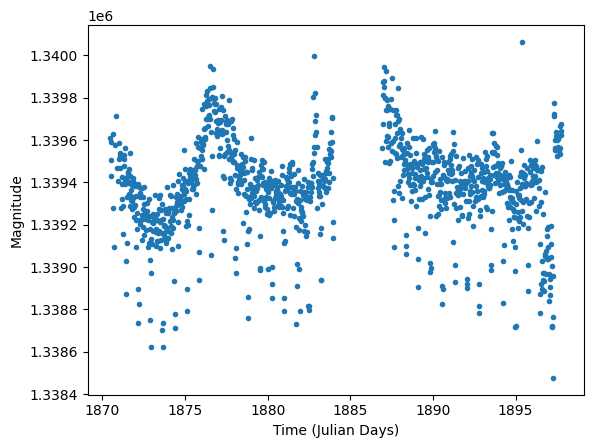

In [7]:
# pick a soundfont to use

#generator = guitar_sampler
generator = copy.copy(flute_sampler)

lightcurve = np.genfromtxt(Path('..', 'data', 'datasets', '55Cancri_lc.dat'))
x = lightcurve[:,0][:]
y = lightcurve[:,1][:]

notes = [["C3","D3","E3","G3","B3","C4","D4","E4","G4","B4","C5","D5","E5","G5","B5"]]
score =  Score(notes, 15)
        
maps = {'pitch':y,
        'time': x}

system = "mono"

# manually set note properties to get a suitable sound
generator.modify_preset({'note_length':0.03, # hold each note for 0.03 seconds or 30 ms - what if this was 1s?
                         'volume_envelope': {'use':'on',
                                            # A,D,R values in seconds, S sustain fraction from 0-1 that note
                                            # will 'decay' to (after time A+D)
                                            'A':0.01,    # ✏️ Time to fade in note to maximum volume, using 10 ms
                                            'D':0.0,    # ✏️ Time to fall from maximum volume to sustained level (s), irrelevant while S is 1 
                                            'S':1.,      # ✏️ fraction of maximum volume to sustain note at while held, 1 implies 100% 
                                            'R':0.07}}) # ✏️ Time to fade out once note is released, using 100 ms

# alternatively can avoid setting manually above anf just load the 'staccato' preset
# generator.load_preset('staccato')

# set 0 to 100 percentile limits so the full pitch range is used...
# setting 0 to 101 for pitch means the sonification is 1% longer than
# the time needed to trigger each note - by making this more than 100%
# we give all the notes time to ring out (setting this at 100% means
# the final note is triggered at the momement the sonification ends)
lims = {'time': ('0','101'),
        'pitch': ('0','100')}

# set up source
sources = Events(maps.keys())
sources.fromdict(maps)
sources.apply_mapping_functions(map_lims=lims)

soni = Sonification(score, sources, generator, system)
soni.render()
dobj = soni.notebook_display(show_waveform=0)

plt.scatter(x,y, marker='.')
plt.ylabel('Magnitude')
plt.xlabel('Time (Julian Days)')

For a different approach, we can use an `Object` source type, where we evolve a sound over time to represent the data. Here we represent the same data using a held chord, and change the _`"cutoff"`_ frequency of the low-pass filter to create a 'brighter' timbre when the star is brighter and a 'darker' sound when the star is darker.

When using samples in this way, we want to achieve certain properties:

- A sound that will last the length of the sonification: To achieve this we can use _"looping"_, where part of the sample is repeated indefinitely, choosing the looping style and start and end points.
- A sound that has little intrinsic variation: for a example a short, percussive sound like a plucked string will lead to large volume variations when looping, that can be distractibg from the variation due to the data we're interested in. An instrument like a violin or organ can loop more smoothly.
- A "harmonically rich" sound: By choosing an instrument with a more trebly or 'bright' timbre, the filter variations will be easier to hear

For example we use an overdriven guitar sound by default. This sound loops well as it fades away slowly, and the distorition makes int harmonically rich. How about trying some other presets for the `guitar_sampler` above by choosing a different `sf_preset` value?

To visualise this we use a line graph - this uses a continuous, varying line to represent the data series, analogous to the evolving sound. In the line graph we see that the data gap is interpolated over, connecting the data points either side of the gap. In the `Object` representation the same effect is heard in the sound - the sound varies smoothly over the gap.

Text(0.5, 0, 'Time (Julian Days)')

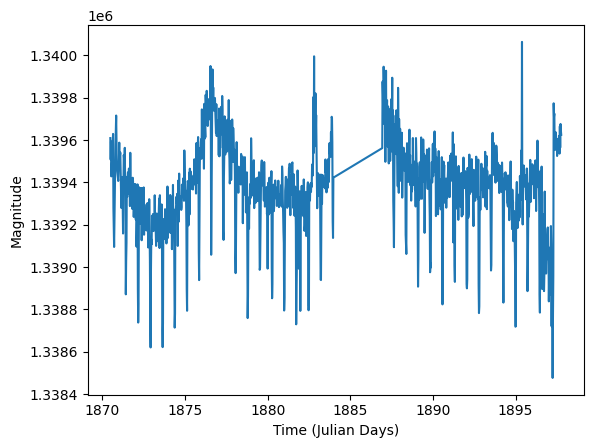

In [8]:
# pick a soundfont to use

generator = copy.copy(guitar_sampler)
#generator = flute_sampler

generator.modify_preset({'filter':'on'})

# manually set looping parameters 
generator.modify_preset({'looping':'forwardback',
                         'loop_start': 0.2, 'loop_end': 0.5}) # ✏️ for such a fast sequence, using ~10 ms values

# or, just load the 'sustain' preset
# generator.load_preset('sustain')

# we use a 'chord' here to create more harmonic richness (stacking fifths)...
notes = [["E2", "B3"]]
score =  Score(notes, 15)

data = {'pitch':[0,1,2,3],
        'time_evo':[x]*4,
        'cutoff':[y]*4}

lims = {'time_evo': ('0','100'),
        'cutoff': ('0','100')}

# set up source
sources = Objects(data.keys())
sources.fromdict(data)
plims = {'cutoff': (0.25,0.95)}
sources.apply_mapping_functions(map_lims=lims, param_lims=plims)

soni = Sonification(score, sources, generator, system)
soni.render()
dobj = soni.notebook_display(show_waveform=0);
plt.plot(x,y)
plt.ylabel('Magnitude')
plt.xlabel('Time (Julian Days)')